# CITS4404 Practical Project

### Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="CamoWorms/velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

### Imports and Global Variables

In [49]:
# Imports
# pip install imageio matplotlib scikit-learn scipy sympy
import random
import warnings
import time
import numpy as np
import imageio.v3 as iio
import math
import copy
#!python -m pip install scikit-image


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier

from skimage.metrics import structural_similarity
from scipy.ndimage import binary_dilation
from scipy.ndimage import gaussian_filter
from shapely.geometry import Polygon
from shapely.prepared import prep
from sklearn.metrics.pairwise import euclidean_distances
from collections import OrderedDict
from typing import List
from typing import Tuple
from typing import Callable


rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images

In [50]:
# Global Variables
IMAGE_DIR = 'MendeleyDataset'
IMAGE_NAME='DME-1102486-2'
MASK = [0, 1000, 0, 1000] # ymin ymax xmin xmax
#IMAGE_DIR = 'CamoWorms/images'
#IMAGE_NAME='DME-1102486-69'
#MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

### Image Preperation

Image name (shape) (intensity max, min, mean, std)

DME-1102486-2 (496, 768) (255, 0, 40.2, 42.8)


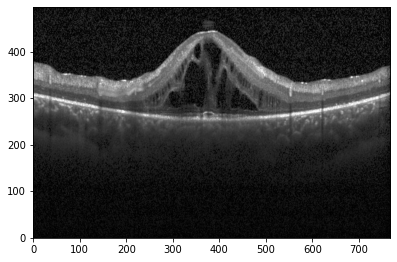

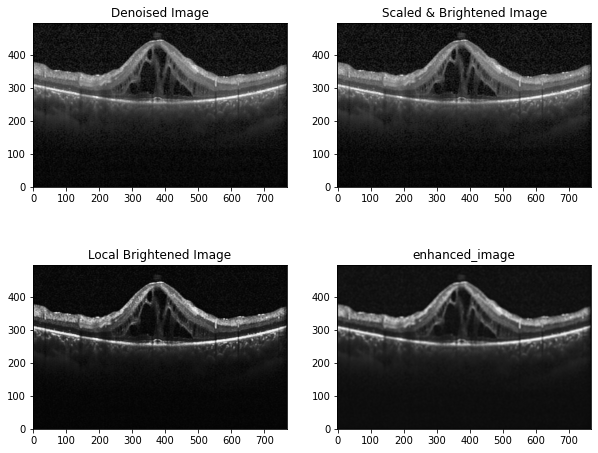

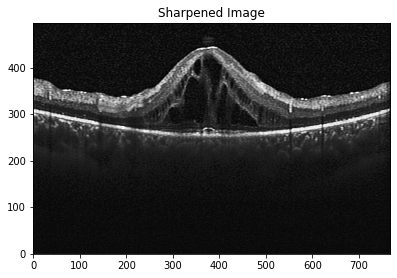

In [51]:
# Read, crop and display image and stats
from scipy import fftpack
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter, convolve


def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".jpeg"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)


def fft_denoise(image, coeff=0.25):    # Perform the Fourier transform.
    image_fft = fftpack.fftshift(fftpack.fft2(image))
    # Create a mask for the low-pass filter.
    w, h = image_fft.shape
    x, y = np.ogrid[:w, :h]
    mask = ((x - w / 2) ** 2 + (y - h / 2) ** 2) < (coeff * min(w, h)) ** 2
    image_fft[~mask] = 0
    # Perform the inverse Fourier transform.
    image_filtered = fftpack.ifft2(fftpack.ifftshift(image_fft)).real
    # Clip values to maintain valid brightness.
    denoised_image = np.clip(image_filtered, 0, 255)
    
    return denoised_image.astype('uint8')

denoised_image = fft_denoise(image)


def scale_brighten(image: np.ndarray) -> np.ndarray:
    """ Scales the darkest pixel is 0, and the brightest is 255. """
    return np.interp(image, (image.min(), image.max()), (0.0, 255.0))


def scale_01(image: np.ndarray) -> np.ndarray:
    """ 
    Scales the image so that the darkest pixel is 0, and the brightest is 1.
    To implementation of the scale_01 function.
    """
    min_val = image.min()
    max_val = image.max()
    # Prevent division by zero if the image is flat
    if min_val == max_val:
        return np.zeros_like(image, dtype=np.float32)
    else:
        return (image - min_val) / (max_val - min_val)



def extremify_flexible(image: np.ndarray, *, coeff=2.0, center=0.5, scale=255) -> np.ndarray:
    """
    Makes dark pixels darker and bright pixels brighter, allows adjustment of the center.
    If coeff is larger, then this is more extreme.
    """
    # Normalize image to [0, 1]
    image_scaled = scale_01(image)
    
    # Remap to [0 - center*2, center*2]
    image_shifted = 2 * (image_scaled - center)
    
    # Apply sigmoid function to enhance contrast
    shifted = 1 / (1 + np.exp(-coeff * image_shifted))
    
    # Scale back to the desired range
    return np.clip(shifted * scale, 0, scale).astype(np.uint8)


def local_brighten(image: np.ndarray, *, local_area_window=20, limit=0.2, scale_coefficient=3.0) -> np.ndarray:
    """ Brightens regions of the image based upon the brightness of their surroundings. """
    # Scale the image into the range [0, 1].
    image = scale_01(image)

    # Use a massive blur to approximate local brightness.
    local_brightness = gaussian_filter(image, sigma=local_area_window)

    # Apply limits so that the image cannot be changed too much.
    np.clip(local_brightness, limit, 1 - limit, out=local_brightness)

    # Shift the image towards its local brightness, away from 0.5.
    shift = 0.3 * (local_brightness - 0.5)
    image += shift

    # Apply the scaling relative to the local brightness.
    locally_brightened = extremify_flexible(image - local_brightness, coeff=scale_coefficient)

    # Combine the original image and the locally brightened image based on the limit.
    return 255 * limit * image + (1 - limit) * locally_brightened


def laplacian_edge_enhance(image: np.ndarray, *, alpha=1.0) -> np.ndarray:
    """
    Enhance edges in an image using the Laplacian operator.
    
    Parameters:
    - image: np.ndarray. The input image.
    - alpha: float. The weight of the edges to be added to the original image.
    
    Returns:
    - An image with enhanced edges.
    """
    # Define a 3x3 Laplacian kernel
    laplacian_kernel = np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])
    
    # Apply the kernel to the image to extract edge information
    laplacian_edges = convolve2d(image, laplacian_kernel, mode='same', boundary='fill', fillvalue=0)
    
    # Enhance edges by adding the Laplacian (scaled by alpha) back to the original image
    # Clamp the values to be in the range [0, 255]
    enhanced_image = np.clip(image + alpha * laplacian_edges, 0, 255)
    
    return enhanced_image.astype(image.dtype)



def sharpen_image(image, *, alpha=1.0) -> np.ndarray:
    # sharpen
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    sharpened = convolve2d(image, sharpen_kernel, mode='same', boundary='fill', fillvalue=0)

    # combine image
    combined = np.clip(image * (1 - alpha) + sharpened * alpha, 0, 255)
    
    return combined.astype('uint8')

scaled_brightened_image = scale_brighten(denoised_image)  
extremified_image = extremify_flexible(scaled_brightened_image)  
local_brightened_image = local_brighten(extremified_image) 
enhanced_image = laplacian_edge_enhance(local_brightened_image, alpha=1.0)
sharpened_image = sharpen_image(local_brightened_image, alpha=0.3)
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(denoised_image, cmap='gray', origin='lower')
plt.title('Denoised Image')

plt.subplot(222)
plt.imshow(scaled_brightened_image, cmap='gray', origin='lower')
plt.title('Scaled & Brightened Image')

plt.subplot(223)
plt.imshow(local_brightened_image, cmap='gray', origin='lower')
plt.title('Local Brightened Image')


plt.subplot(224)
plt.imshow(enhanced_image, cmap='gray', origin='lower')
plt.title('enhanced_image')


plt.show()

plt.imshow(sharpened_image, cmap='gray', origin='lower')
plt.title('Sharpened Image')
plt.show()


### Camo Worms and Drawing Them

In [52]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)


In [53]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None, title=None):
        if save is not None:
            plt.savefig(save)
        if title is not None:
            plt.title(title, fontdict={"fontsize": 25, "fontweight": 900})
        plt.show()

### Random Worms and Clews

In [54]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

In [55]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

[[200.         180.        ]
 [217.7312124  157.32018935]
 [200.          20.        ]]


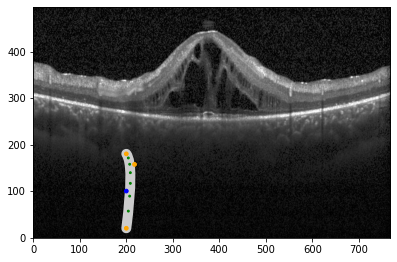

In [56]:
# Draw a single worm along with control points and some sample points

# (x, y, r, theta, deviation_r, deviation_gamma, width, colour)
worm = Camo_Worm(200, 100, 80, np.radians(270), 60, np.pi-0.3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
print(worm.control_points())
drawing.add_dots((200,100), color='blue')

### Cost Function

In [57]:
def points_filter(points, *, point_interval=7):
    """
    Basically here to improve efficiency by removing unneeded points
    """
    # Calculate distances between adjacent points
    offsets = points[:-1] - points[1:]
    distances = np.sqrt(np.sum(offsets**2, axis=1))

    # Adjust the point_interval to evenly space the points
    total_distance = np.sum(distances)
    point_interval = total_distance / np.ceil(total_distance / point_interval)

    # Create an array to use as a filter for the points
    n_points = len(points)
    point_filter = np.zeros(n_points, dtype=bool)
    point_filter[0] = True  # Keep the first point

    # Find the indices where the cumulative distance exceeds the interval
    cumulative_distances = np.cumsum(distances)
    filter_indices = np.searchsorted(cumulative_distances, np.arange(point_interval, total_distance, point_interval))
    point_filter[filter_indices] = True

    # Keep the last point
    point_filter[-1] = True

    # Apply the filter
    return points[point_filter]

In [58]:
class CircleMask:
    
    cache_size = 100  # Maximum number of cached CircleMasks
    cache = OrderedDict()  # LRU cache

    def __init__(self, radius: float):
        self.radius = radius

        # The radius may be fractional, but we need whole pixels.
        self.width = math.ceil(radius) * 2
        self.topLeft_x = -math.ceil(radius)
        self.topLeft_y = -math.ceil(radius)

        # Removing Jagged Edge
        
        x_coords = []
        y_coords = []
        
        # Iterate over each pixel in the mask
        for i in range(self.width):
            # Calculate the x-coordinate for each column
            x = self.topLeft_x + i
            x_coords.append([x] * self.width)  # Append the x-coordinate for each pixel in the column
        
            # Calculate the y-coordinates for each row
            y_values = [self.topLeft_y + j for j in range(self.width)]
            y_coords.append(y_values)  # Append the y-coordinates for the entire row
        
        # Convert the lists of x and y coordinates into NumPy arrays
        xx = np.array(x_coords)
        yy = np.array(y_coords)
        dist_from_center = np.sqrt(xx ** 2 + yy ** 2)

        sigma = 0.1 * radius 
        self.mask = (dist_from_center < radius).astype(float)
        self.mask = gaussian_filter(self.mask, sigma)

    def draw(self, target_mask, x, y):
        x = int(x)
        y = int(y)

        # Calculate the bounds in the target mask to paste the circle.
        target_from_x = max(0, x + self.topLeft_x)
        target_from_y = max(0, y + self.topLeft_y)
        target_to_x = min(target_mask.shape[0] - 1, x + self.topLeft_x + self.width)
        target_to_y = min(target_mask.shape[1] - 1, y + self.topLeft_y + self.width)
        if target_from_x >= target_to_x or target_from_y >= target_to_y:
            return

        # Calculate the bounds in the circle mask to paste.
        circle_from_x = target_from_x - x - self.topLeft_x
        circle_from_y = target_from_y - y - self.topLeft_y
        circle_to_x = target_to_x - x - self.topLeft_x
        circle_to_y = target_to_y - y - self.topLeft_y

        # Add the circle mask into the target mask.
        target_area = target_mask[target_from_x:target_to_x, target_from_y:target_to_y]
        source_area = self.mask[circle_from_x:circle_to_x, circle_from_y:circle_to_y]
        np.maximum(target_area, source_area, out=target_area)


    @staticmethod
    def Caching(radius):
        """
        searching for cached circle to save computational time
        """
        # Quantize the radius (if needed)
        quantized_radius = round(radius, 1)  # Quantize to two decimal places (adjust as needed)
    
        # Check if the quantized radius is in the cache
        if quantized_radius in CircleMask.cache:
            # Move the item to the end to mark it as most recently used
            CircleMask.cache.move_to_end(quantized_radius)
            return CircleMask.cache[quantized_radius]
    
        # Create a new circle mask if not found
        mask = CircleMask(quantized_radius)
    
        # Cache the new circle mask
        if len(CircleMask.cache) >= CircleMask.cache_size:
            # If the cache is full, evict the least recently used item
            CircleMask.cache.popitem(last=False)  # Remove the first item
        CircleMask.cache[quantized_radius] = mask
    
        return mask

In [59]:
class WormMask:
    def __init__(self, worm, image, *, copy: 'WormMask'=None):
        self.worm = worm
        self.image = image

        if copy is None:
            # Worm Information
            img_width = image.shape[0]
            img_height = image.shape[1]
            radius = worm.width / 2 
            self.points = worm.bezier(np.linspace(0, 1, num=400))
            self.min_x = max(0, math.floor(np.amin(self.points[:, 1])) - math.ceil(radius*1.5))
            self.min_y = max(0, math.floor(np.amin(self.points[:, 0])) - math.ceil(radius*1.5))
            max_x = min(img_width, math.ceil(np.amax(self.points[:, 1])) + math.ceil(radius*1.5))
            max_y = min(img_height, math.ceil(np.amax(self.points[:, 0])) + math.ceil(radius*1.5))
            width = max_x - self.min_x
            height = max_y - self.min_y

            # If the worm is outside of the image
            if width <= 0 or height <= 0:
                self.min_x = 0
                self.min_y = 0
                self.mask = np.zeros((1, 1))
            else:
                self.points = points_filter(self.points, point_interval=radius/2)
                n_points = self.points.shape[0]
                self.n_points = self.points.shape[0]  

                # 3. Apply a circle mask at each point on the curve to the mask.
                self.mask = np.zeros((width, height))
                circle_mask = CircleMask.Caching(radius)
                for y, x in self.points:
                    circle_mask.draw(self.mask, x - self.min_x, y - self.min_y)

            self.area = np.sum(self.mask)
            self.width = self.mask.shape[0]
            self.height = self.mask.shape[1]
            self.max_x = self.min_x + self.width
            self.max_y = self.min_y + self.height
        else:
            self.min_x = copy.min_x
            self.min_y = copy.min_y
            self.max_x = copy.max_x
            self.max_y = copy.max_y
            self.width = copy.width
            self.height = copy.height
            self.mask = copy.mask
            


    
    def create_outer_mask(self) -> 'WormMask':
        
        distance = max(1, round(self.worm.width / 2.0))
    
        # Dilate the original mask to create the outer mask
        dilated_mask = binary_dilation(self.mask, iterations=distance)
        # Subtract the original mask to remove the inner worm
        dilated_mask = np.maximum(dilated_mask - self.mask, 0)
        # Create a copy of the existing worm mask
        outer_mask = WormMask(self.worm, self.image, copy=self)
    
        # Update the properties of the outer mask
        outer_mask.min_x -= distance
        outer_mask.min_y -= distance
        outer_mask.max_x += distance
        outer_mask.max_y += distance
        outer_mask.width += 2 * distance
        outer_mask.height += 2 * distance
        outer_mask.mask = np.zeros((outer_mask.width, outer_mask.height))
    
        # Update the outer mask with the dilated mask
        outer_mask.mask[distance:distance+self.width, distance:distance+self.height] = dilated_mask
        # Crop the mask to the bounds of the image.
        min_x = max(0, outer_mask.min_x)
        min_y = max(0, outer_mask.min_y)
        max_x = min(self.image.shape[0], outer_mask.max_x)
        max_y = min(self.image.shape[1], outer_mask.max_y)
    
        # Extract the desired region directly from the mask array.
        outer_mask.mask = outer_mask.mask[min_x - outer_mask.min_x:max_x - outer_mask.min_x, min_y - outer_mask.min_y:max_y - outer_mask.min_y]
    
        outer_mask.min_x = min_x
        outer_mask.min_y = min_y
        outer_mask.max_x = max_x
        outer_mask.max_y = max_y
    
        # Update the dimensions of the mask.
        outer_mask.width = max_x - min_x
        outer_mask.height = max_y - min_y
        # Update the area of the mask.
        outer_mask.area = np.sum(dilated_mask)
        return outer_mask

        

    def image_within_bounds(self, image=None):

        image = self.image if image is None else image

        # Get the subset of the image corresponding to this mask.
        return image[self.min_x:self.max_x, self.min_y:self.max_y] / 255.0

    def image_under_mask(self, image=None):

        # Apply the mask to the image.
        return self.image_within_bounds(image) * self.mask

    def difference_image(self, image=None):
        """
        This applies this mask to the image, to calculate the differences
        between the colour of the worm and all the pixels beneath the worm.
        """
        # 1. Calculate the difference of the colour of the worm to its background.
        diff_image = np.absolute(self.image_under_mask(image) - self.worm.colour)

        # 2. Apply the mask to the difference.
        return diff_image * self.mask


    def subsection(self, min_x, min_y, max_x, max_y):
        """
        Gets the subsection of this mask that covers the given coordinates.
        """
        # Check if the specified coordinates are completely outside the bounding box
        if max_x <= self.min_x or max_y <= self.min_y or min_x >= self.max_x or min_y >= self.max_y:
            return None
        
        # Adjust the coordinates to ensure they fall within the bounding box
        min_x = max(self.min_x, min_x)
        min_y = max(self.min_y, min_y)
        max_x = min(self.max_x, max_x)
        max_y = min(self.max_y, max_y)
        
        # Use array slicing to extract the subsection directly, avoiding unnecessary copying
        return self.mask[min_x - self.min_x: max_x - self.min_x, min_y - self.min_y: max_y - self.min_y]
    
    def intersection(self, other: 'WormMask'):
        """
        Calculates the area that intersects between this mask and other.
        """
        sub_self = self.subsection(other.min_x, other.min_y, other.max_x, other.max_y)
        if sub_self is None:
            return 0

        sub_other = other.subsection(self.min_x, self.min_y, self.max_x, self.max_y)
        return 2 * np.sum(np.minimum(sub_self, sub_other)) / max(1, self.area + other.area)




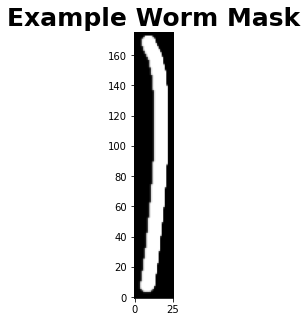

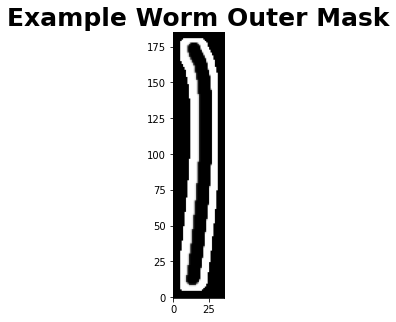

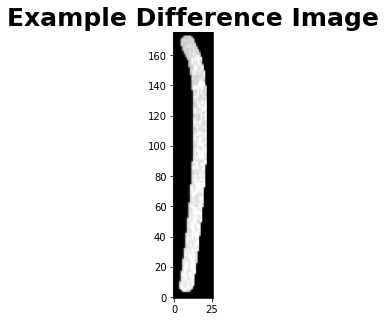

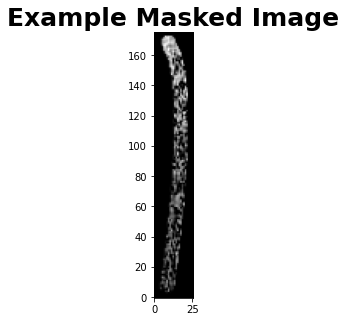

Area = 1553.4, Intersection = 0.1


In [60]:
    # Compare the generated mask with the worm used in the example above.
worm_mask = WormMask(worm, image)
Drawing(worm_mask.mask * 255).show(title="Example Worm Mask")
Drawing(worm_mask.create_outer_mask().mask * 255).show(title="Example Worm Outer Mask")
Drawing(worm_mask.difference_image() * 255).show(title="Example Difference Image")
Drawing(worm_mask.image_under_mask() * 255).show(title="Example Masked Image")
    
example_intersecting_worm = Camo_Worm(200, 100 + 5, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
intersecting_worm_mask = WormMask(example_intersecting_worm, image)
print("Area = {:.1f}, Intersection = {:.1f}".format(worm_mask.area, worm_mask.intersection(intersecting_worm_mask)))